# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
import os
import os.path
import cv2
import random
import pickle
import numpy as np 
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle
import csv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from itertools import product

/home/carnd/anaconda3/envs/CarND-LeNet-Lab/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


---
## Step 0: Load The Data

In [2]:
def get_files():
    '''
    Helper function to get the pickled data file paths.
    TODO: Get a better way to the data. It might be better to 
          download an unpack the pickeled data.
    '''
    DATA_PATH="/home/carnd/data"
    return (os.path.join(DATA_PATH, "train.p"), 
            os.path.join(DATA_PATH, "test.p"))

def get_csv_file():
    '''
    Helper function to get the traffic sign names CSV file.
    '''
    cwd = os.getcwd()
    filename = os.path.join(cwd, "signnames.csv")
    return filename

def get_test_image_path():
    '''
    Helper function to get the test images directory
    '''
    cwd = os.getcwd()
    path = os.path.join(cwd,"test_images")
    return path

In [3]:
'''
Helper functions to preprocess images.
'''

def rgb2gray(func):
    def func_wrapper(*args, **kwargs):
        return cv2.cvtColor(func(*args, **kwargs), cv2.COLOR_RGB2GRAY)
    return func_wrapper

def gray2rgb(func):
    def func_wrapper(*args, **kwargs):
        return cv2.cvtColor(func(*args, **kwargs), cv2.COLOR_GRAY2RGB)
    return func_wrapper

def gray2equalizeHist(func):
    def func_wrapper(*args, **kwargs):
        return cv2.equalizeHist(func(*args, **kwargs))
    return func_wrapper
        
def rgb2hsv(func):
    def func_wrapper(*args, **kwargs):
        return cv2.cvtColor(func(*args, **kwargs), cv2.COLOR_RGB2HSV)
    return func_wrapper

def hsv2rgb(func):
    def func_wrapper(*args, **kwargs):
        return cv2.cvtColor(func(*args, **kwargs), cv2.COLOR_HSV2RGB)
    return func_wrapper

def hsv2equalizeHist(func):
    def func_wrapper(*args, **kwargs):
        h,s,v = cv2.split(func(*args, **kwargs))
        v = cv2.equalizeHist(v)
        return cv2.merge((h,s,v))
    return func_wrapper

def rgb2normalize(func):
    def func_wrapper(*args, **kwargs):
        r,g,b = cv2.split(func(*args, **kwargs))
        x = r.copy()
        r = cv2.normalize(r,x)
        g = cv2.normalize(g,x)
        b = cv2.normalize(b,x)        
        return cv2.merge((r,g,b))
    return func_wrapper    
def no_image(image):
    return image

def rgb2randomRotate(func):
    def func_wrapper(*args, **kwargs):
        img = func(*args, **kwargs)
        rotation = random.uniform(-5, 5)
        rotation_x = random.uniform(-5,5)
        rotation_y = random.uniform(-5,5)        
        (rows,cols,ch) = img.shape
        M = cv2.getRotationMatrix2D((cols/2+rotation_x,rows/2+rotation_y),rotation,1)
        dst = cv2.warpAffine(img,M,(cols,rows))
        return dst
    return func_wrapper    
def no_image(image):
    return image

def rgb2randomTranslate(func):
    def func_wrapper(*args, **kwargs):
        img = func(*args, **kwargs)
        (rows,cols,ch) = img.shape
        rotation_x = random.uniform(-5, 5)
        rotation_y = random.uniform(-5, 5 )
        M = np.float32([[1,0,rotation_x],[0,1,rotation_y]])
        dst = cv2.warpAffine(img,M,(cols,rows))        
        return dst
    return func_wrapper    
def no_image(image):
    return image

@rgb2randomTranslate
def translate_image(image):
    return image

@rgb2randomRotate
def rotate_image(image):
    return image

@rgb2normalize
def norm_image(image):
    return image

@gray2rgb
@gray2equalizeHist
@rgb2gray
def gray_image(image):
    return image

@hsv2rgb
@hsv2equalizeHist
@rgb2hsv
def image2(image):
    return image

def translate_images(images):
    X = [ translate_image(features) for features in images]
    Y = X
    return Y

def convert_images(images):
    X = [ no_image(features) for features in images]
    Y = X
    return Y

def create_images(images):
    X = [ rotate_image(features) for features in images]
    Y = X
    return Y

<a id='create_additional_data'>&nbsp;</a>
Load the test and train data and enhance the test data with further generated data.

Goto [implementation](#implementation).

In [4]:
# Load pickled data
training_file, testing_file = get_files()

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

'''
Create some additional data from the original test data.
Add some rotated and translated images.
'''
train['original_features'] = train['features']
train['features'] = np.concatenate((convert_images(train['features']), 
                                    create_images(train['features']),
                                    create_images(train['features']), 
                                    create_images(train['features']),
                                    translate_images(train['features'])
                                   ))
'''
Ensure that the labels have the same size and contain the right data.
'''
train['labels'] = np.concatenate((train['labels'], 
                                  train['labels'],
                                  train['labels'],
                                  train['labels'],
                                  train['labels']))
test['features'] = convert_images(test['features'])

X_train, X_validation, y_train, y_validation = train_test_split(train['features'], train['labels'], test_size=0.20, random_state=42)
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [5]:
### Replace each question mark with the appropriate value.
n_original_train = len(train['original_features'] )
n_train = len(X_train)
n_validation = len(X_validation)
n_test = len(X_test)
image_shape = [len(X_train[0]),len(X_train[0][0]),len(X_train[0][0][0])]
n_classes = len(set(y_train))

print("Number of loaded training examples =", n_original_train)
print("Number of enhanced training examples minus the extracted validation examples =", n_train)
print("Number of enhanced validation examples extracted from enhanced training examples =", n_validation)
print("Number of loaded testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of loaded training examples = 39209
Number of enhanced training examples minus the extracted validation examples = 156836
Number of enhanced validation examples extracted from enhanced training examples = 39209
Number of loaded testing examples = 12630
Image data shape = [32, 32, 3]
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [6]:
'''
Get the traffic sign names
'''
with open(get_csv_file(), 'rt') as csvfile:
    spamreader = csv.DictReader(csvfile, delimiter=',', quotechar='|')
    signname = [ row['SignName'] for row in spamreader]

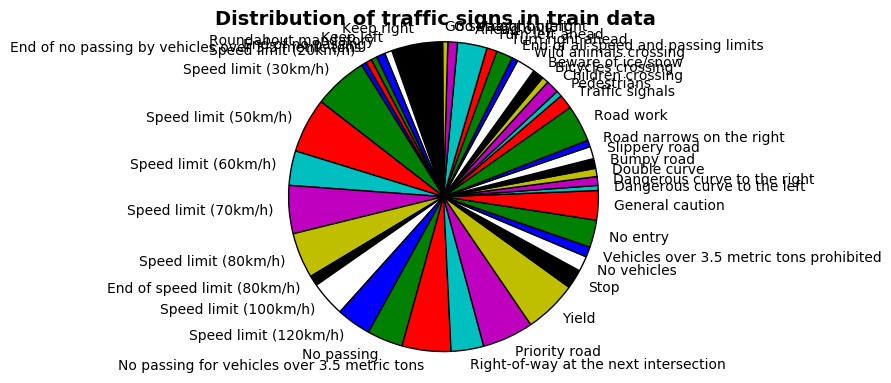

In [7]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
# Visualizations will be shown in the notebook.
%matplotlib inline

# Show the distribution of traffic signs in the test set.
foo = np.unique(y_train,return_counts=True)
count = foo[1]
plt.suptitle("Distribution of traffic signs in train data", fontsize=14, fontweight='bold')
plt.pie(count, labels=signname,shadow=False,startangle=120)
plt.axis('equal')

plt.show()

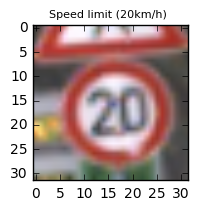

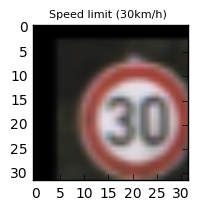

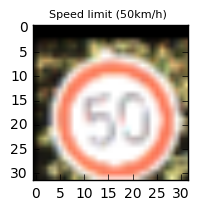

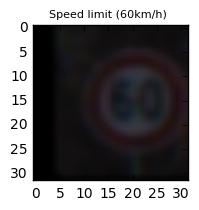

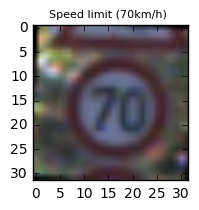

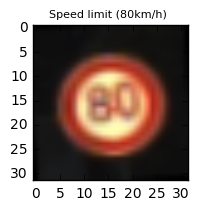

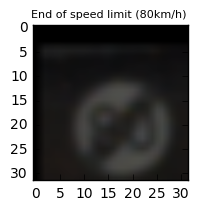

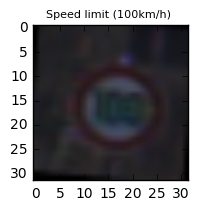

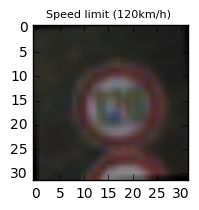

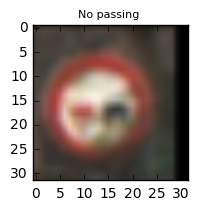

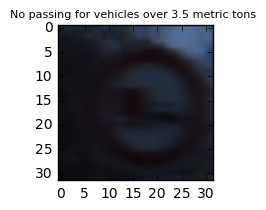

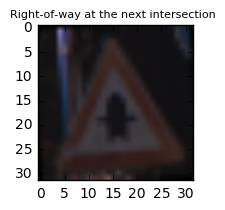

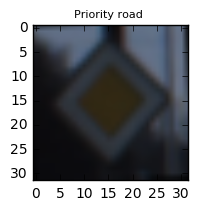

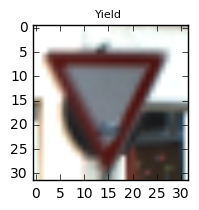

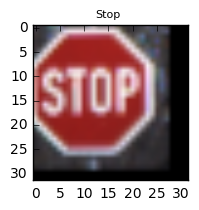

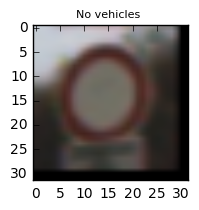

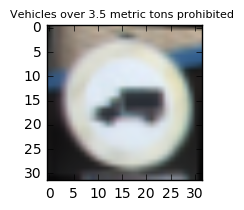

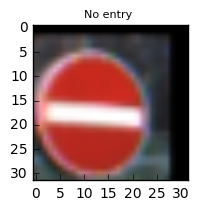

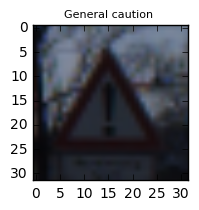

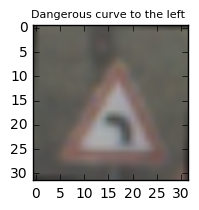

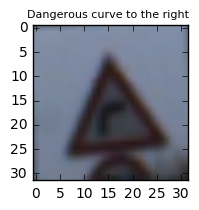

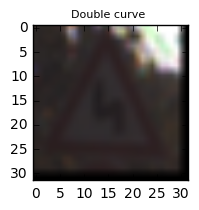

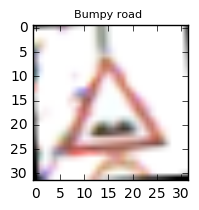

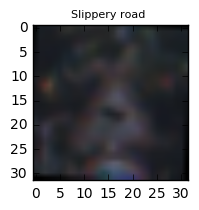

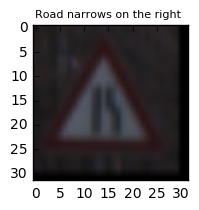

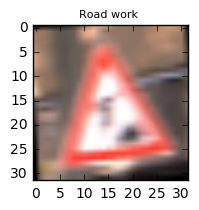

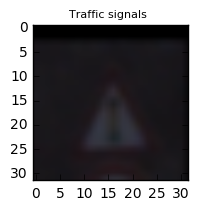

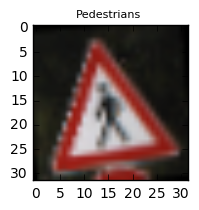

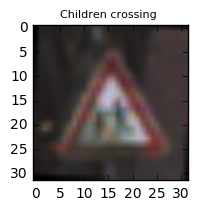

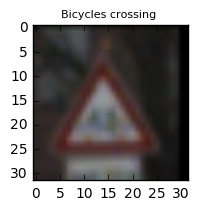

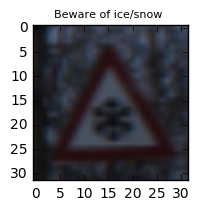

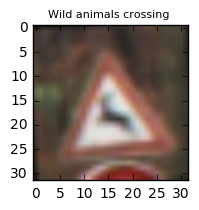

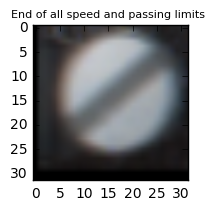

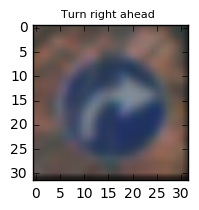

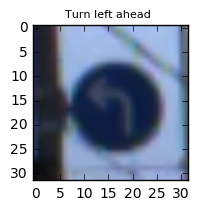

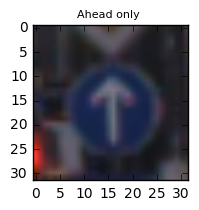

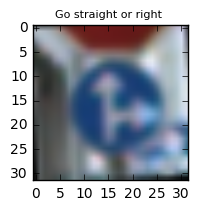

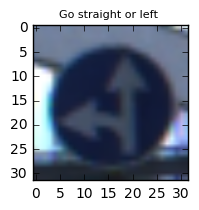

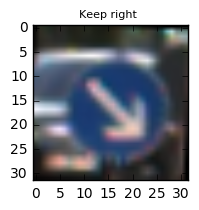

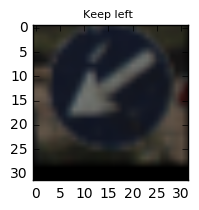

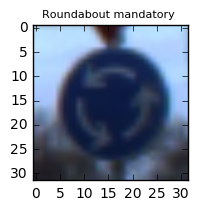

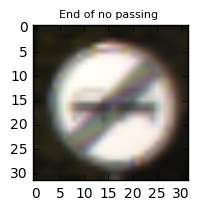

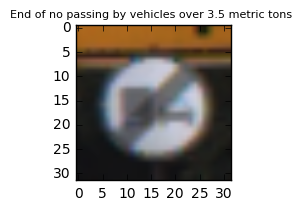

In [8]:
# Plot the first occurence of each sign
fig_size = [2,2]
plt.rcParams["figure.figsize"] = fig_size
for i in range(len(signname)):
    a = np.where(y_train==i)[0][0]
    plt.suptitle(signname[i], fontsize=8)
    plt.imshow(X_train[a])
    plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [9]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
pass

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

I've tried several ways to preprocess the data:
* Convert to a grayscale image.
* Convert to a grayscale image and equalize the histogram.
* Convert from an RGB to a HSV (hue, saturation and value) image.
* Equalize the histogram of each channel from an RGB image.
* Convert to a HSV image, equalize the histogram of V and convert it back to an RGB image.

Unfortunately none of these methods improved the accuracy of the validation data. Finally, I decided not to preprocess the data.
For the sake of completeness I've left the conversion implementation in the notebook. 
But I've generated additional data out of the loaded training data (see below).

In [10]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
pass

Already done in the [cell above](#create_additional_data)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

### Additional data
I created additional data using rotation and translation.
The rotation is applied randomly with a degree of -5 to +5 degree. The center of the rotation is also randomly set -5 to +5 pixels in both directions from the center of the image.

The translation (shift of the image) was applied -5 to +5 pixels in both directions.

I've added more rotated images than translated images to the training set as they improved the accuracy of the validation set.

The creation of the additional data was done in the [cell above](#create_additional_data)

### Set up the data
The validation data was extracted from the loaded and with additional data enhanced test data. 20% of the test data has been used for the validation data.

The testing data is just the data loaded from the pickled test data.

In [11]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

EPOCHS = 40
BATCH_SIZE = 64

In [12]:
def nprint(c):
    """
    print the input tensor and return it
    """
    print(c)
    return c

def LeNet_mod(x):   
    '''
    A modified network based on the LeNet model.
    The input tensor x needs to have a shape of (?, 32, 32, <depth>).
    It will return a graph representing the modified LeNet model
    '''
    (unknown, width, height, depth) = x.get_shape()

    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    weights = {
        'wc1': tf.Variable(tf.truncated_normal([5, 5, int(depth), 6], mean=mu, stddev=sigma)), 
        'wc2': tf.Variable(tf.truncated_normal([1, 1, 6, 6], mean=mu, stddev=sigma)), 
        'wc3': tf.Variable(tf.truncated_normal([1, 1, 6, 6], mean=mu, stddev=sigma)),
        'wc4': tf.Variable(tf.truncated_normal([5, 5, 6, 16], mean=mu, stddev=sigma)),
        'wfc1': tf.Variable(tf.truncated_normal([400, 120], mean=mu, stddev=sigma)),
        'wfc2': tf.Variable(tf.truncated_normal([120, 84], mean=mu, stddev=sigma)),
        'out': tf.Variable(tf.truncated_normal([84, n_classes], mean=mu, stddev=sigma))
    }


    biases = {
        'bc1': tf.Variable(tf.truncated_normal([6], mean=mu, stddev=sigma)),
        'bc2': tf.Variable(tf.truncated_normal([6], mean=mu, stddev=sigma)),
        'bc3': tf.Variable(tf.truncated_normal([6], mean=mu, stddev=sigma)),
        'bc4': tf.Variable(tf.truncated_normal([16], mean=mu, stddev=sigma)),
        'bfc1': tf.Variable(tf.truncated_normal([120], mean=mu, stddev=sigma)),
        'bfc2': tf.Variable(tf.truncated_normal([84], mean=mu, stddev=sigma)),
        'out': tf.Variable(tf.truncated_normal([n_classes], mean=mu, stddev=sigma))
    }  
    
    ksize = [1, 2, 2 , 1]
    strides = [1, 2, 2, 1]
    padding = 'VALID'
    
    c = x
    print("Layer 1")
    c = nprint(tf.nn.conv2d(c, weights['wc1'], strides=[1, 1, 1, 1], padding='VALID', name="C1.conv2d"))
    c = nprint(tf.nn.bias_add(c, biases['bc1'], name="C1.bias"))
    c = nprint(tf.nn.relu(c, name="C1.relu"))
    
    print("Layer 2")    
    c = nprint(tf.nn.conv2d(c, weights['wc2'], strides=[1, 1, 1, 1], padding='VALID', name="C2.conv2d"))
    c = nprint(tf.nn.bias_add(c, biases['bc2'], name="C2.bias"))
    c = nprint(tf.nn.relu(c, name="C2.relu"))
    
    print("Layer 3")    
    c = nprint(tf.nn.conv2d(c, weights['wc3'], strides=[1, 1, 1, 1], padding='VALID', name="C3.conv2d"))
    c = nprint(tf.nn.bias_add(c, biases['bc3'], name="C3.bias"))
    c = nprint(tf.nn.relu(c, name="C3.relu"))
    
    print("Pooling 1")    
    c = nprint(tf.nn.max_pool(c, ksize, strides, padding, name="P1.max_pool"))
    
    print("Layer 4")    
    c = nprint(tf.nn.conv2d(c, weights['wc4'], strides=[1, 1, 1, 1], padding='VALID', name="C4.conv2d"))
    c = nprint(tf.nn.bias_add(c, biases['bc4'], name="C4.bias"))    
    c = nprint(tf.nn.relu(c, name="C4.relu"))
    
    print("Pooling 2")     
    c = nprint(tf.nn.max_pool(c, ksize, strides, padding, name="P2.max_pool"))

    print("Flatten")        
    c = nprint(flatten(c))

    print("Dropout")        
    c = nprint(tf.nn.dropout(c, keep_prob, name="Dropout"))

    print("Fully Connected 1")    
    c = nprint(tf.add(tf.matmul(c, weights['wfc1']), biases['bfc1'], name="fc1.matmul"))
    c = nprint(tf.nn.relu(c, name="fc1.relu")) 

    print("Fully Connected 2")        
    c = nprint(tf.add(tf.matmul(c, weights['wfc2']), biases['bfc2'], name="fc2.matmul"))
    c = nprint(tf.nn.relu(c, name="fc2.relu"))
    
    print("Fully Connected 3")    
    logits = nprint(tf.add(tf.matmul(c, weights['out']), biases['out'], name="out"))
    return logits

In [13]:
x = tf.placeholder(tf.float32, (None, image_shape[0], image_shape[1], image_shape[2]), name="x")
y = tf.placeholder(tf.int32, (None), name="y")
# on dropout
keep_prob = tf.placeholder(tf.float32, name="keep_prob")
one_hot_y = tf.one_hot(y, n_classes)

In [14]:
rate = 0.0005

logits = LeNet_mod(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

Layer 1
Tensor("C1.conv2d:0", shape=(?, 28, 28, 6), dtype=float32)
Tensor("C1.bias:0", shape=(?, 28, 28, 6), dtype=float32)
Tensor("C1.relu:0", shape=(?, 28, 28, 6), dtype=float32)
Layer 2
Tensor("C2.conv2d:0", shape=(?, 28, 28, 6), dtype=float32)
Tensor("C2.bias:0", shape=(?, 28, 28, 6), dtype=float32)
Tensor("C2.relu:0", shape=(?, 28, 28, 6), dtype=float32)
Layer 3
Tensor("C3.conv2d:0", shape=(?, 28, 28, 6), dtype=float32)
Tensor("C3.bias:0", shape=(?, 28, 28, 6), dtype=float32)
Tensor("C3.relu:0", shape=(?, 28, 28, 6), dtype=float32)
Pooling 1
Tensor("P1.max_pool:0", shape=(?, 14, 14, 6), dtype=float32)
Layer 4
Tensor("C4.conv2d:0", shape=(?, 10, 10, 16), dtype=float32)
Tensor("C4.bias:0", shape=(?, 10, 10, 16), dtype=float32)
Tensor("C4.relu:0", shape=(?, 10, 10, 16), dtype=float32)
Pooling 2
Tensor("P2.max_pool:0", shape=(?, 5, 5, 16), dtype=float32)
Flatten
Tensor("Flatten/Reshape:0", shape=(?, 400), dtype=float32)
Dropout
Tensor("Dropout/mul:0", shape=(?, 400), dtype=float32)
Fu

In [15]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ... Validation Accuracy = {:.3f}".format(i+1,validation_accuracy))
        
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess,'/home/carnd/lenet')
    print("Model saved")

Training...

EPOCH 1 ... Validation Accuracy = 0.869
EPOCH 2 ... Validation Accuracy = 0.911
EPOCH 3 ... Validation Accuracy = 0.932
EPOCH 4 ... Validation Accuracy = 0.947
EPOCH 5 ... Validation Accuracy = 0.959
EPOCH 6 ... Validation Accuracy = 0.962
EPOCH 7 ... Validation Accuracy = 0.961
EPOCH 8 ... Validation Accuracy = 0.973
EPOCH 9 ... Validation Accuracy = 0.974
EPOCH 10 ... Validation Accuracy = 0.977
EPOCH 11 ... Validation Accuracy = 0.974
EPOCH 12 ... Validation Accuracy = 0.976
EPOCH 13 ... Validation Accuracy = 0.979
EPOCH 14 ... Validation Accuracy = 0.981
EPOCH 15 ... Validation Accuracy = 0.983
EPOCH 16 ... Validation Accuracy = 0.982
EPOCH 17 ... Validation Accuracy = 0.982
EPOCH 18 ... Validation Accuracy = 0.985
EPOCH 19 ... Validation Accuracy = 0.983
EPOCH 20 ... Validation Accuracy = 0.984
EPOCH 21 ... Validation Accuracy = 0.986
EPOCH 22 ... Validation Accuracy = 0.986
EPOCH 23 ... Validation Accuracy = 0.987
EPOCH 24 ... Validation Accuracy = 0.986
EPOCH 25 ...

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

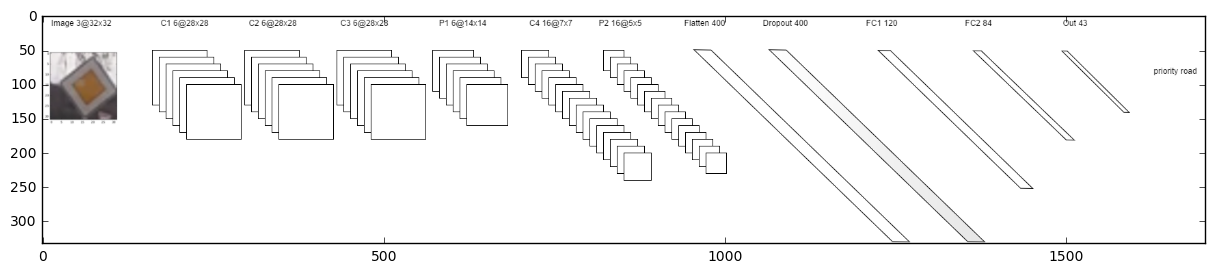

In [17]:
# Usually I'd embed the image using markdown, but then it can't be exported into html
fig_size = [15,9]
plt.rcParams["figure.figsize"] = fig_size
image = cv2.imread("network.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

The network architecture is based on LeNet. In addition I took some inspiration from [VGGNet](https://arxiv.org/pdf/1409.1556.pdf) and added additionally a dropout layer.
The network is build with following layers:

1. Input layer: Takes a 32x32 Image with an( arbitrary number of channels. In this class the rgb channels have been used.
2. Convolution network 1 (C1): The output shape will be 6@28x28
3. Convolution network 2 (C2): The output shape will be 6@28x28. *Change to original LeNet*.
4. Convolution network 3 (C3): The output shape will be 6@28x28. *Change to original LeNet*.
5. Pooling layer 1 (P1): The output shape is reduced to 6@14x14.
6. Convolution network 4 (C4): The output shape will be 16@7x7. 
7. Pooling layer 2 (P2): The output shape is reduced to 16@5x5.
8. Flattening from 3D to 1D with 400 Features.
9. Dropout layer. *Change from original LeNet*
10. Fully connected Layer 1 (FC1). Reduce to 120 Features.
10. Fully connected Layer 2 (FC2). Reduce to 84 Features.
10. Final output layer 1 (Out). Reduce to final 43 possible traffic sign features.

In the description I left out the RelU and Bias layers from the implementation. They can be seen exactly when calling the `LeNet_mod(x)` function (see above).




In [18]:
# Finally use the test set to evaluate how good the model was trained.

with tf.Session() as sess:
    loader = tf.train.import_meta_graph('/home/carnd/lenet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('/home/carnd/'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.967


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

In [19]:
print("Learning rate: ", rate)
print("Epochs: ", EPOCHS)
print("Batch size: ", BATCH_SIZE)

Learning rate:  0.0005
Epochs:  40
Batch size:  64


* Hyperparameters
 * mu = 0
 * sigma = 0.1
* Optimizer: Adam using softmax and one hot encoding

Once I increased the amount of training data and epochs, I used the Amazon could service as otherwise the calculations would have taken too long on my computer.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

As it was suggested I started with the LeNet we've learned in the classroom. 
In additional I've  looked into other networks (especially VGGNet). 
I've tried to create a model based on VGGNet to cope with the type of image but the results were not as good as with LeNet.
Instead I tried to mix both models, however adding more convolutional layers to the end of the LeNet also was not as good.
Adding them to the beginning several layers with 6@28x28 improved the model.
I also tried to add the dropout layer into different stages. The best results have been seen directly after flattening.

Each new network I've tried with the different preprocess approches but was never able to get any better results.

During testing I've discovered that lowering the learning rate and increasing the epochs was better for the learning algorithm. 

I've also reduced the batch size as a colleague suggested that. This also improved the network

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

------8<-------file: 13__yield__dashcam.png --------8<-----
-->  1.0 13 Yield
 1.82177e-13 12 Priority road
 2.82804e-14 25 Road work
 1.30101e-14 28 Children crossing
 1.58117e-15 2 Speed limit (50km/h)


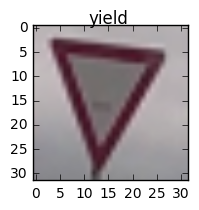

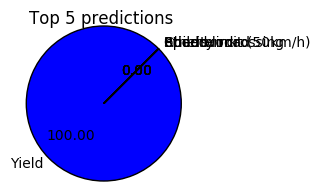

------8<-------file: 13__yield__drawing.png --------8<-----
-->  1.0 13 Yield
 1.03752e-19 15 No vehicles
 1.84387e-23 14 Stop
 1.24892e-25 12 Priority road
 4.67392e-27 1 Speed limit (30km/h)


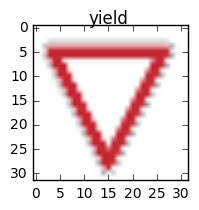

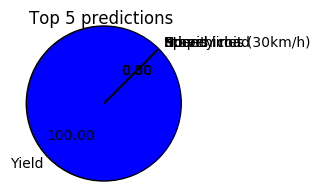

------8<-------file: 1__speedlimit_30__wikipedia.png --------8<-----
-->  0.999653 1 Speed limit (30km/h)
 0.000346339 0 Speed limit (20km/h)
 2.66951e-07 5 Speed limit (80km/h)
 2.30241e-07 2 Speed limit (50km/h)
 4.72043e-08 40 Roundabout mandatory


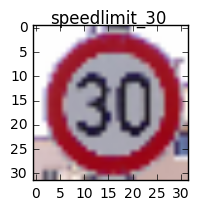

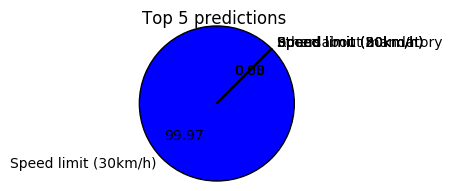

------8<-------file: 21__double_curve-2__dashcam.png --------8<-----
 0.713571 28 Children crossing
 0.23531 20 Dangerous curve to the right
 0.0450196 23 Slippery road
 0.00607403 30 Beware of ice/snow
 1.55493e-05 29 Bicycles crossing


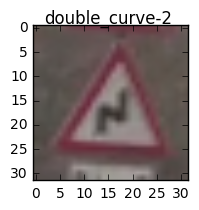

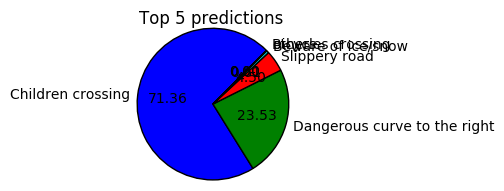

------8<-------file: 21__double_curve__dashcam.png --------8<-----
 0.6519 20 Dangerous curve to the right
 0.180464 18 General caution
 0.0465458 23 Slippery road
 0.0327906 11 Right-of-way at the next intersection
 0.0246857 28 Children crossing


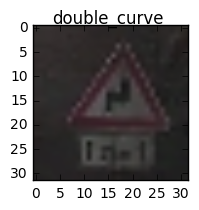

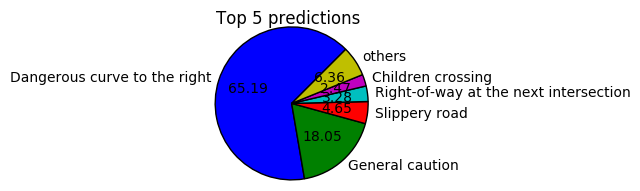

------8<-------file: 11__right_of_way_on_the_next_intersection_2__dashcam.png --------8<-----
-->  0.851893 11 Right-of-way at the next intersection
 0.0809133 40 Roundabout mandatory
 0.0430181 12 Priority road
 0.00782833 38 Keep right
 0.00307343 21 Double curve


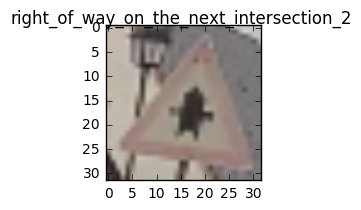

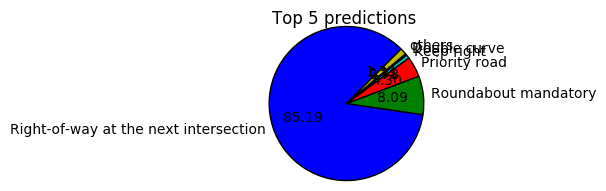

------8<-------file: 14__stop__dashcam.png --------8<-----
-->  0.999843 14 Stop
 0.00010501 17 No entry
 1.25997e-05 5 Speed limit (80km/h)
 9.91646e-06 3 Speed limit (60km/h)
 7.33064e-06 12 Priority road


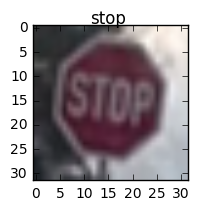

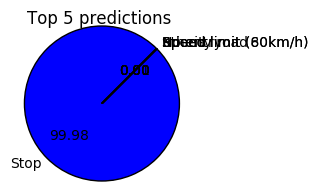

------8<-------file: 1__speedlimt_30__dashcam.png --------8<-----
-->  0.993671 1 Speed limit (30km/h)
 0.00573601 0 Speed limit (20km/h)
 0.000316779 4 Speed limit (70km/h)
 0.000184789 2 Speed limit (50km/h)
 8.82415e-05 5 Speed limit (80km/h)


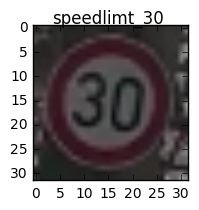

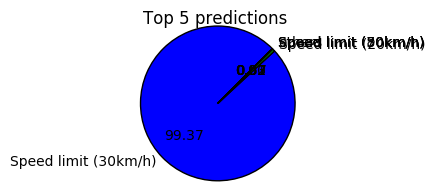

------8<-------file: 4__speelimit_70__dashcam.png --------8<-----
-->  1.0 4 Speed limit (70km/h)
 1.77758e-12 2 Speed limit (50km/h)
 6.64668e-14 1 Speed limit (30km/h)
 4.36236e-16 0 Speed limit (20km/h)
 1.45977e-16 24 Road narrows on the right


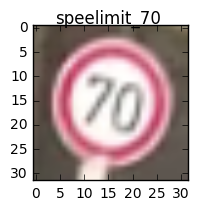

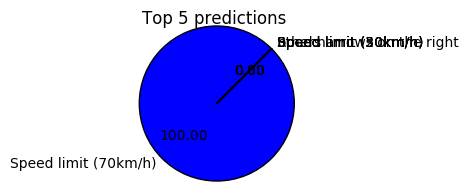

------8<-------file: 35__ahead_only__dashcam.png --------8<-----
 0.828917 23 Slippery road
 0.0366768 20 Dangerous curve to the right
 0.0264077 41 End of no passing
 0.0219787 0 Speed limit (20km/h)
 0.0188536 22 Bumpy road


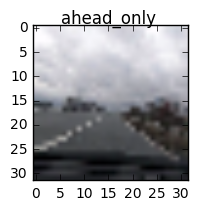

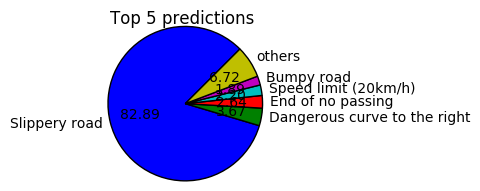

------8<-------file: 11__right_of_way_on_the_next_intersection_1__dashcam.png --------8<-----
-->  1.0 11 Right-of-way at the next intersection
 5.93427e-08 30 Beware of ice/snow
 8.34838e-09 27 Pedestrians
 5.00982e-09 21 Double curve
 4.2396e-10 18 General caution


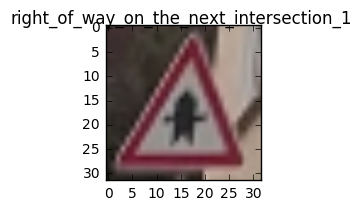

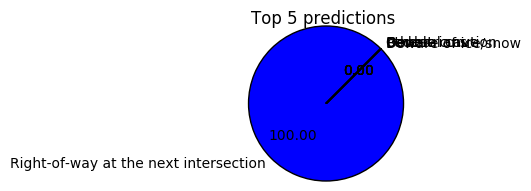

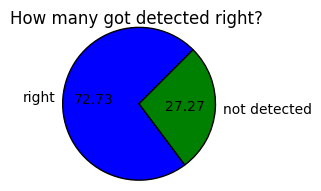

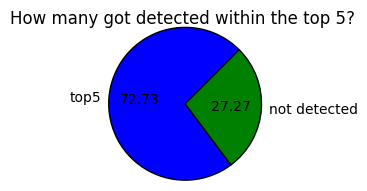

In [20]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
fig_size = [2,2]
plt.rcParams["figure.figsize"] = fig_size

dirs = os.listdir(get_test_image_path())
image_batch = []
top1_predicted = 0
top5_predicted = 0

class test_image:
    number = -1
    name = "unknown"
    source = "unknown"
    
    def __init__(self,myfile):
        splitted = myfile.split('__')
        self.number=int(splitted[0])
        self.name=splitted[1]
        self.source=splitted[2]
    
for mfile in dirs:
    img = cv2.imread(os.path.join(get_test_image_path(),mfile))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    (width, heigth, channels) = img.shape
    z=width
    step=(width+heigth)*2
    for (xx,yy) in product(range(0,width,step),range(0,heigth,step)):
        small_img = resized_image = cv2.resize(img, (32, 32)) 
        image_batch.append(np.copy(small_img))
    
with tf.Session() as sess:
    """
    Do the predictions on the test images
    """
    loader = tf.train.import_meta_graph('/home/carnd/lenet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('/home/carnd/'))
    predictions = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=5), feed_dict={x: image_batch, keep_prob: 1.0})
    
for myfile, value, predicted, num in zip(dirs,predictions[0], predictions[1],range(len(predictions[0]))):
    """
    Print the result of the prediction.
    Show if the traffic sign from the image is in the top5.
    Show the image
    Show the softmax distribution of the image (the top5 vs the rest)
    Show how many images have been found correctly
    Show how many images have correct predictions within the top5
    """
    print("------8<-------file: "+myfile+" --------8<-----")
    #arg= np.argmax(predicted)
    ti = test_image(myfile)
    for i in range(len(value)):
        p = ""
        if predicted[i] == ti.number:
            p = "--> "
            top5_predicted += 1
            if i == 0:
                top1_predicted +=1
        print(p, value[i], predicted[i], signname[predicted[i]])
    #if predicted[arg]>0.1 :
    plt.suptitle(ti.name, fontsize=12)
    plt.imshow(image_batch[num])
    plt.show()
    count = np.append(np.copy(value), [1-np.sum(value)])
    labels = [signname[px] for px in predicted]
    labels.append("others")
    plt.suptitle("Top 5 predictions", fontsize=12)
    plt.pie(count, labels=labels,shadow=False,autopct='%.2f',startangle=45)
    plt.axis('equal')
    plt.show()


count = [top1_predicted, len(dirs)-top1_predicted]
plt.suptitle("How many got detected right?", fontsize=12)
plt.pie(count, labels=["right", "not detected"],shadow=False,autopct='%.2f',startangle=45)
plt.axis('equal')
plt.show()

count = [top5_predicted, len(dirs)-top5_predicted]
plt.suptitle("How many got detected within the top 5?", fontsize=12)
plt.pie(count, labels=["top5", "not detected"],shadow=False,autopct='%.2f',startangle=45)
plt.axis('equal')
plt.show()


(738, 720, 3)


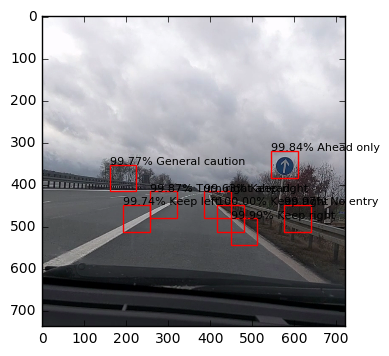

In [25]:
# Further look into the complete scene 35__ahead_only__dashcam.png
# Create subimages with a stride of 32 and a size of 64. Reduce them to 32x32 images
# Run the classifier on all the images.
# Show the image including the subimages which detected an image with more then 90%.

%matplotlib inline
image_batch = []
cropped_image_batch = []

mfile = "35__ahead_only__dashcam.png"
fig,ax = plt.subplots(1)
image = cv2.imread(os.path.join(get_test_image_path(),mfile))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ax.imshow(image)
(width, heigth, channels) = image.shape
print(image.shape)
z=64
step=32
for (xx,yy) in product(range(0,width,step),range(0,heigth,step)):
    small_img = cv2.resize(image[xx:xx+z,yy:yy+z], (32, 32)) 
    image_batch.append(np.copy(small_img))
    cropped_image_batch.append((xx,yy,z,z))
    
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('/home/carnd/lenet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('/home/carnd/'))
    predictions = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=5), feed_dict={x: image_batch, keep_prob: 1.0})
    
which_cropped = []
which_prediction = []
which_name = []
for value, predicted, num, cropped in zip(predictions[0], predictions[1],range(len(predictions[0])),cropped_image_batch):
    ti = test_image(mfile)
    #if predicted[0] == ti.number:
    if value[0]>0.996:
        which_cropped.append(cropped)
        which_prediction.append(value[0])
        which_name.append(signname[predicted[0]])


c = 0
for (yy,xx,width,height) in which_cropped:
    rect = patches.Rectangle((xx,yy),width,height,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    ax.text(xx, yy,  "{:.2f}% {}".format(which_prediction[c]*100, which_name[c]), fontsize=8)
    c = c+1
plt.show()

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In the above implementation there are 

In the implementations above I did all the predictions and plotting. So here I'd refer to some of the images.

* 13\__yield\__drawing.png: 
 * Basically 100% prediction. 
 * This was a cleanroom drawing of the yield image and it seems that the algorithm is really good in detecting these.
* 35\__ahead\_only\__dashcam.png:
 * Did not predict the traffic sign at all.
 * This was a complete image from the dashcam I took. Here it seems that the sign just got too small to be able to get detected. As of this I created another test with this image (see above) to scan through the image to detect in the subimages traffic signs. There are two very interesting things here to see:
   * The yield sign get's detected.
   * Also every subimage detects something (some are with a very high probability .. see the image). This happens as I did not train the model to distinguish images with no traffic signs from traffic signs. So every image need to be an traffic sign (somehow). Further rework is needed to handle this.
* 21\__double_curve-2\__dashcam.png and 21\__double_curve\__dashcam.png:
 * Did not predict the traffic signs at all.
 * At least the detected sign also had triangles, the inside is more complex than others and in most cases there is another sign below (in white) showing further explanations. Since the signs are very similar, the bad prediction could have happened as of this.
* 11\__right_of_way_on_the_next_intersection_2\__dashcam.png:
 * The sign was predicted with 85%
 * It's very interesting to see that from the top 5 the second and third have completely different shapes (priority road and roundaboud mandatory). The low prediction could be caused as the red around the triangle is already very pale and barely recognizable.
 
In general it seems that the triangle traffic signs with the tip on top are harder to detect. They usually have also some higher predictions within the top 5. With the other images the prediction was always nearly a 100% (excluding the full image from the dashcam). 

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In the implementations above I did all the predictions and plotting.

There is a pie chart stating "how many got detected right?". From all the tested images I've got 72.73% images right. So the detection rate is not as good as with training or test set. 

Looking at the top 5 in the prediction, the detection rate actually did not change (see pie chart "How many got detected with top 5?"). So either the traffic sign got detected right or it was not even in the top 5.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

Please see especially question 6 and question 7 for the answer.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.